# Quantum Convolutional Neural Networks (QCNN) for Audio Spectrogram Classification 
- A Hybrid Approach to Quantum Machine Learning

## Import Libraries
This cell imports the necessary libraries:
- **NumPy, Matplotlib**: For numerical operations and visualization.
- **Librosa**: For audio processing and spectrogram generation.
- **PennyLane**: For quantum machine learning and simulation.
- **Autograd**: For automatic differentiation.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pennylane as qml
from pennylane.templates.embeddings import AmplitudeEmbedding
from pennylane import numpy as pnp
import autograd.numpy as anp

## Spectrogram Generation
This function generates and visualizes the spectrogram for a given audio files.

In [77]:
def plot_spectrogram(audio_file):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram of {audio_file}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

## Data Loading and Processing
This function processes audio files into normalized spectrograms for training/testing.
- **Inputs**: 
  - `audio_files`: List of audio file paths.
  - `labels`: Corresponding binary labels.
  - `num_features`: Feature size for quantum embedding.
  - `test_split`: Proportion of test data.
- **Outputs**: Train/test data splits: `X_train, X_test, Y_train, Y_test`.


## Load and Display Spectrograms

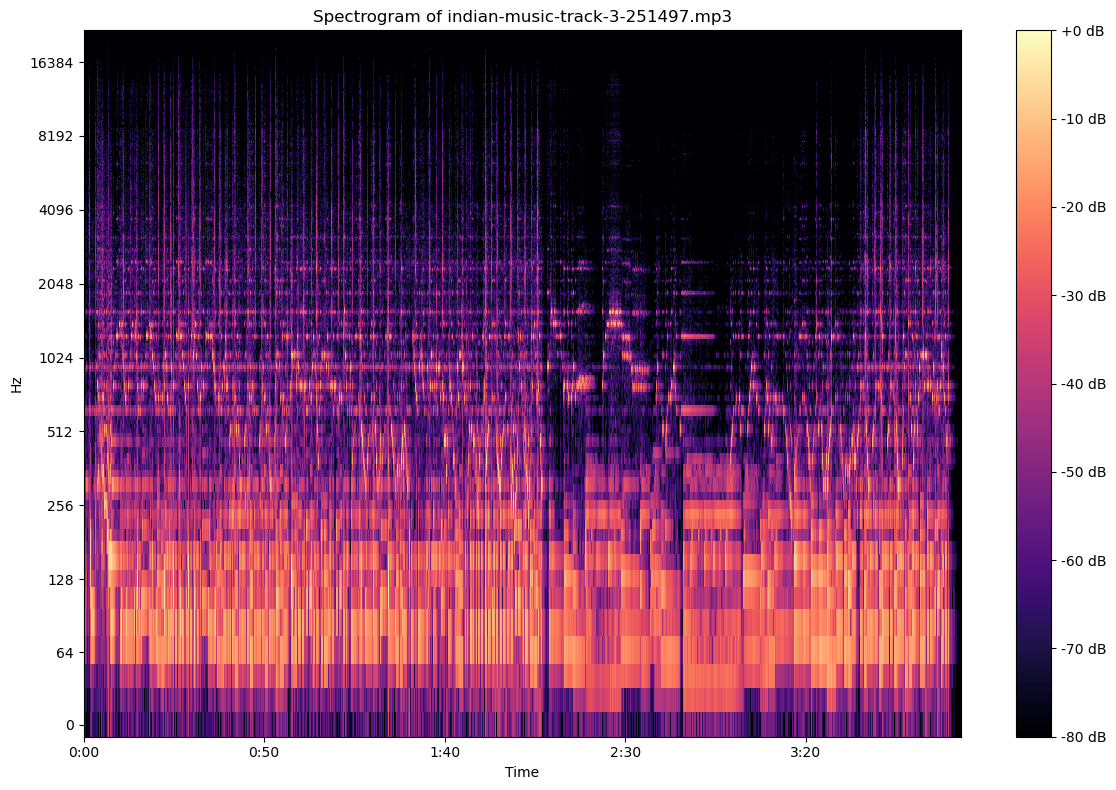

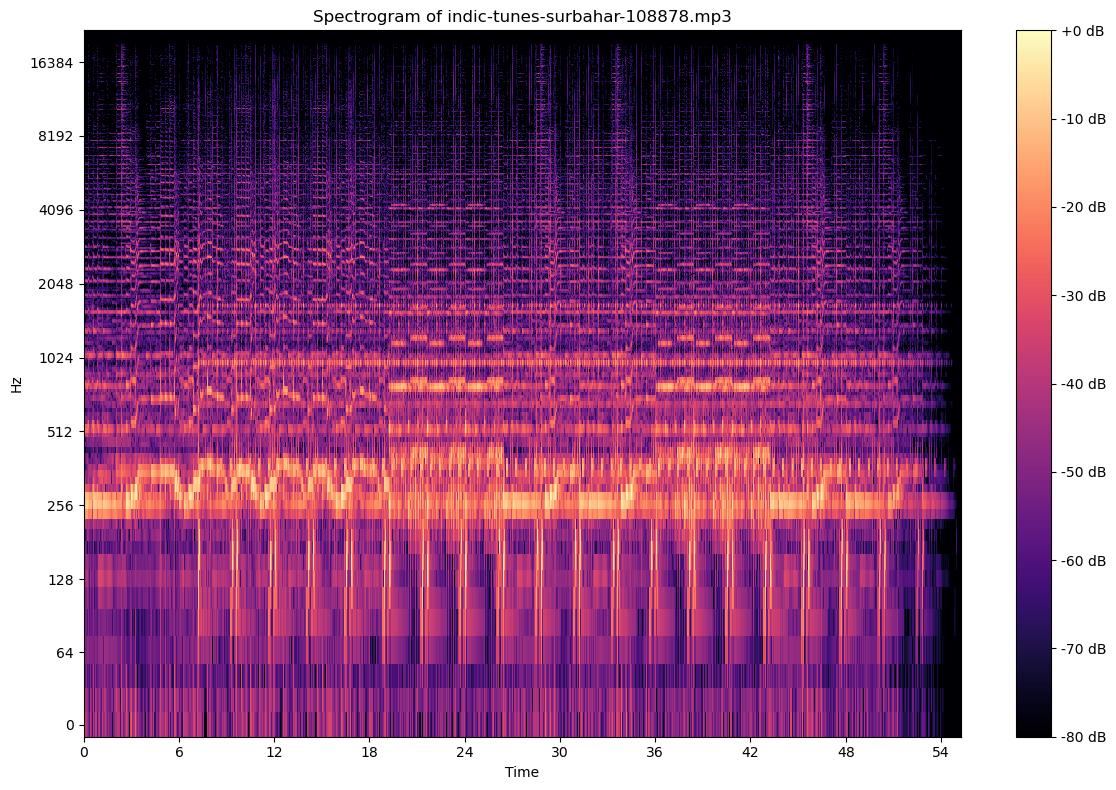

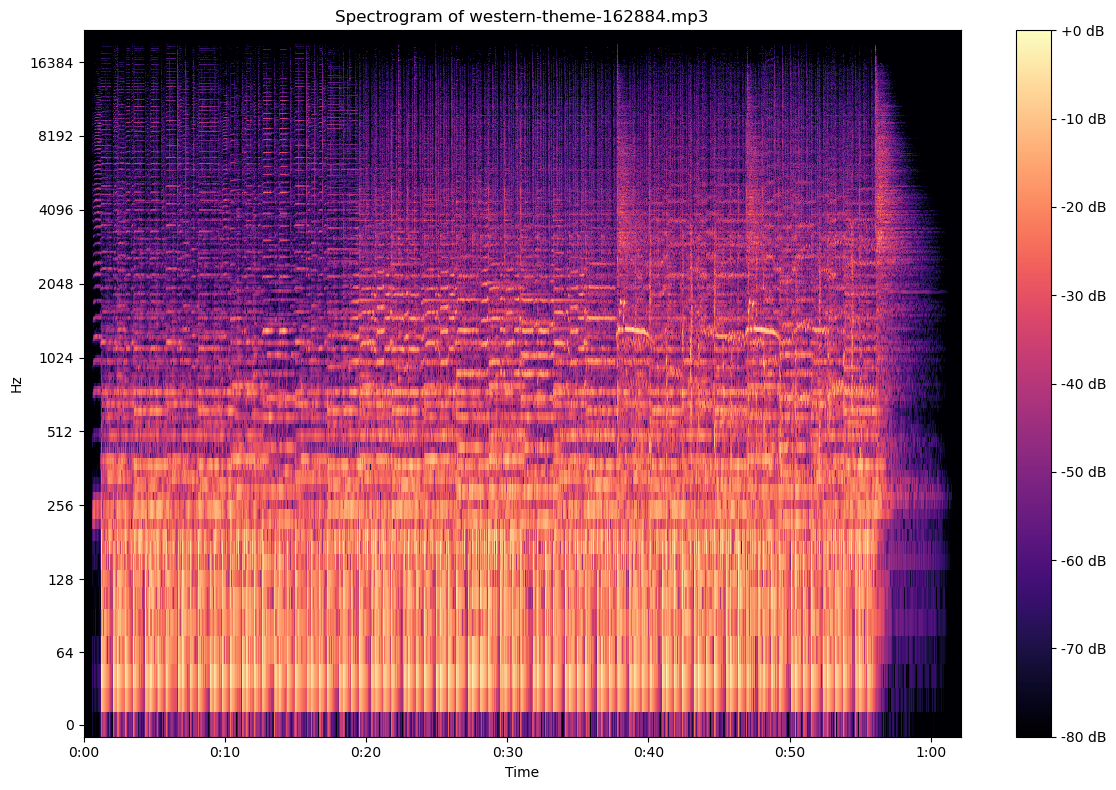

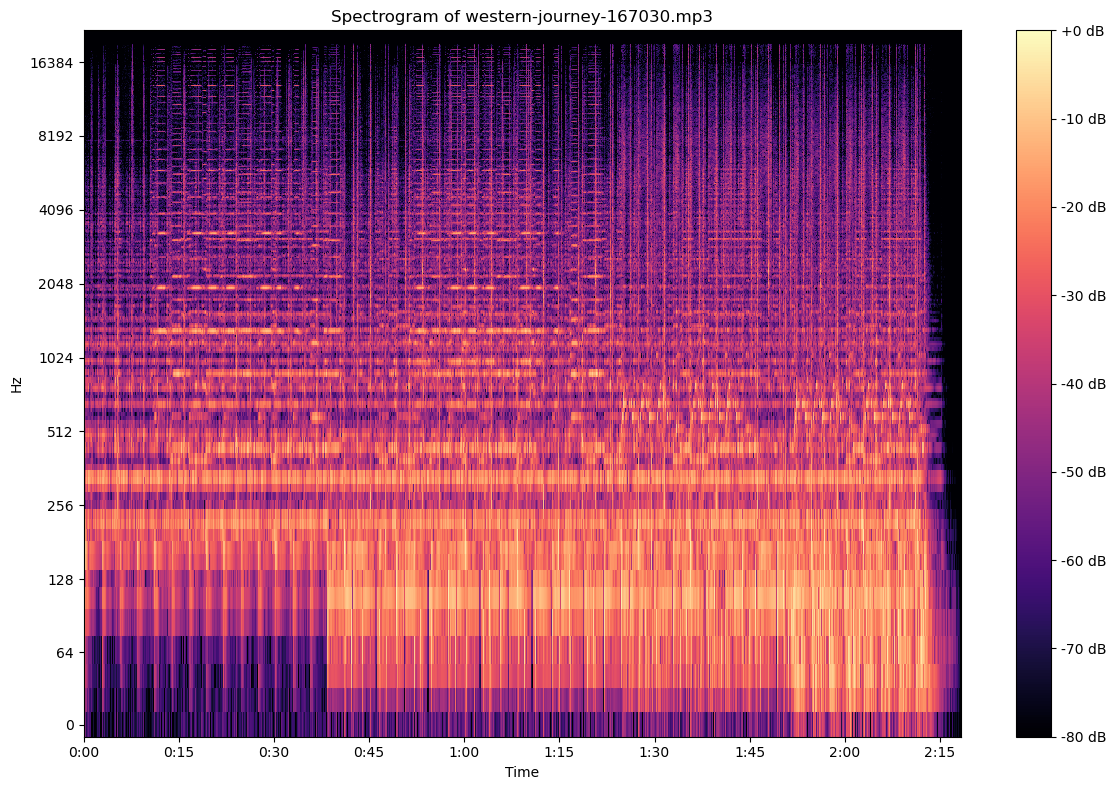

In [78]:
# List of MP3 files to process
audio_files = ["indian-music-track-3-251497.mp3", "indic-tunes-surbahar-108878.mp3", "western-theme-162884.mp3", "western-journey-167030.mp3"]

# Generate spectrogram for each file
for audio_file in audio_files:
    plot_spectrogram(audio_file)

## CNN-based classifier for the spectogram data and find the accuracy results

### Augment_audio Method
- **Purpose**: To artificially expand the dataset through data augmentation, creating variations of the same audio file (e.g., pitch-shifted, time-stretched).
- **Why for CNN**:
  - CNNs benefit from diverse training data to prevent overfitting.
  - By augmenting the spectrogram inputs, CNNs can learn generalized features.
- **Usage**: Augment audio files before converting them to spectrograms and feeding them into the CNN.

In [ ]:
import librosa
import soundfile as sf

def augment_audio(file):
    augmented_files = []
    try:
        y, sr = librosa.load(file, sr=None)
        
        # Noise injection
        noise = 0.005 * np.random.randn(len(y))
        y_noise = y + noise
        noise_file = file.replace('.mp3', '_noise.mp3')
        sf.write(noise_file, y_noise, sr)
        augmented_files.append(noise_file)
        
        # Equalization
        y_eq = librosa.effects.preemphasis(y)
        eq_file = file.replace('.mp3', '_eq.mp3')
        sf.write(eq_file, y_eq, sr)
        augmented_files.append(eq_file)
        
    except Exception as e:
        print(f"Error in advanced augmentation for {file}: {e}")
    return augmented_files

In [ ]:
from sklearn.model_selection import train_test_split
import librosa.display
import numpy as np
from tensorflow.image import resize

# Function to preprocess audio files into spectrogram data for CNN
from sklearn.model_selection import train_test_split
import librosa.display
import numpy as np
from tensorflow.image import resize

def prepare_cnn_data(audio_files, labels, num_features=(128, 128), test_split=0.2):
    X, Y = [], []

    for idx, file in enumerate(audio_files):
        try:
            # Include original file and augmented data
            all_files = [file] + augment_audio(file)
            for audio in all_files:
                y, sr = librosa.load(audio, sr=None)
                D = librosa.stft(y)
                S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
                
                # Resize to fixed dimensions
                S_resized = resize(S_db[..., np.newaxis], size=num_features)
                X.append(S_resized.numpy())
                Y.append(labels[idx])  # Keep same label for augmented data
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Ensure arrays are not empty
    if len(X) == 0 or len(Y) == 0:
        raise ValueError("No valid samples found. Ensure audio files are accessible and processable.")

    X = np.array(X)
    Y = np.array(Y)

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_split, random_state=42)

    return X_train, X_test, Y_train, Y_test

# CNN Model Definition
def build_optimized_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),  # Dropout to reduce overfitting
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout before final layer
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.add(tf.keras.layers.Dropout(0.25))
    
    return model

# Updated audio file paths and labels
audio_files = ["indian-music-track-3-251497.mp3", "indic-tunes-surbahar-108878.mp3", 
               "western-theme-162884.mp3", "western-journey-167030.mp3"]
labels = [0, 0, 1, 1]

try:
    X_train, X_test, Y_train, Y_test = prepare_cnn_data(audio_files, labels)
    print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")
except Exception as e:
    print(f"Pipeline failed: {e}")


# Convert labels to one-hot encoding
Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes=2)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes=2)

# Build and compile the CNN model
cnn_model = build_cnn_model(X_train.shape[1:])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, Y_train_onehot, epochs=10, batch_size=2, validation_split=0.2)

# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, Y_test_onehot, verbose=0)
print(f"Final CNN Accuracy: {accuracy * 100:.2f}%")

# Predictions and accuracy
Y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
final_accuracy = accuracy_score(Y_test, Y_pred)
print(f"Final CNN Accuracy using sklearn: {final_accuracy * 100:.2f}%")

Training Data Shape: (9, 128, 128, 1), Testing Data Shape: (3, 128, 128, 1)
Epoch 1/10
4/4 [==============================] - 0s 41ms/step - loss: 102.4638 - accuracy: 0.4286 - val_loss: 8.2197 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 21ms/step - loss: 15.2964 - accuracy: 0.2857 - val_loss: 5.8902 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 0s 19ms/step - loss: 3.4939 - accuracy: 0.5714 - val_loss: 11.7346 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 0s 19ms/step - loss: 8.6331 - accuracy: 0.4286 - val_loss: 3.3422 - val_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.4035 - accuracy: 0.8571 - val_loss: 5.2899 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 19ms/step - loss: 4.0144 - accuracy: 0.5714 - val_loss: 0.6203 - val_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 0s 20ms/step - loss: 0.5855 - accura

## Data Preprocessing for Quantum Models
Processes audio data into spectrograms, normalizes them, and splits them into training and testing datasets, preparing them for QCNN input

In [62]:
def data_load_and_process(audio_files=None, labels=None, num_features=256, test_split=0.2):
    if audio_files is None:
        audio_files = ["indian-music-track-3-251497.mp3", "western-theme-162884.mp3"]
    if labels is None:
        labels = [0, 1]

    spectrograms = []
    for file in audio_files:
        try:
            y, sr = librosa.load(file, sr=None)
            D = librosa.stft(y)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            S_flattened = S_db.flatten()
            if len(S_flattened) >= num_features:
                S_resized = S_flattened[:num_features]
            else:
                S_resized = np.pad(S_flattened, (0, num_features - len(S_flattened)), mode='constant')

            S_normalized = S_resized / np.linalg.norm(S_resized)
            spectrograms.append(S_normalized)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

    X = np.array(spectrograms)
    Y = np.array(labels)

    split_index = int(len(X) * (1 - test_split))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]

    return X_train, X_test, Y_train, Y_test

## Quantum Circuit Components
Defines modular building blocks for the Quantum Convolutional Neural Network (QCNN), including:
- **Unitary gates**: E.g., `U_TTN`.
- **Convolutional layers**: Apply quantum operations.
- **Pooling layers**: Reduce quantum states.

In [63]:
# Quantum Circuit Components
def U_TTN(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

def U_5(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

# Quantum Circuits for Convolutional layers
def conv_layer1(U, params):
    U(params, wires=[0, 7])
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])

def conv_layer2(U, params):
    U(params, wires=[0, 6])
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])

def conv_layer3(U, params):
    U(params, wires=[0,4])

## Define Pooling Strategies
Pooling layers reduce the size of the quantum data, similar to classical pooling in CNNs.

In [64]:
# Pooling layers

def Pooling_ansatz1(params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])

def pooling_layer2(V, params):
    V(params, wires=[2,0])
    V(params, wires=[6,4])

def pooling_layer3(V, params):
    V(params, wires=[0,4])

## QCNN Structure
Defines the full QCNN architecture, including convolutional and pooling layers.

In [65]:
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]
    param4 = params[3 * U_params: 3 * U_params + 2]
    param5 = params[3 * U_params + 2: 3 * U_params + 4]
    param6 = params[3 * U_params + 4: 3 * U_params + 6]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param4)
    conv_layer2(U, param2)
    pooling_layer2(Pooling_ansatz1, param5)
    conv_layer3(U, param3)
    pooling_layer3(Pooling_ansatz1, param6)

def QCNN_structure_without_pooling(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 3 * U_params]

    conv_layer1(U, param1)
    conv_layer2(U, param2)
    conv_layer3(U, param3)

def QCNN_1D_circuit(U, params, U_params):
    param1 = params[0: U_params]
    param2 = params[U_params: 2*U_params]
    param3 = params[2*U_params: 3*U_params]

    for i in range(0, 8, 2):
        U(param1, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(param1, wires=[i, i + 1])

    U(param2, wires=[2,3])
    U(param2, wires=[4,5])
    U(param3, wires=[3,4])

## QCNN Circuit
Implements the QCNN with amplitude embedding and modular structure. The output is based on the cost function:
- **Cross-entropy**: Returns probabilities.
- **Mean-squared error**: Returns expectation value.

## The dev variable initializes a quantum device. In this example "default.qubit" with 8 wires is used.

In [66]:
import pennylane as qml

# Define the QCNN quantum node
dev = qml.device('default.qubit', wires = 8)
@qml.qnode(dev)
def QCNN(X, params, U, U_params, cost_fn='cross_entropy'):

    # Data Embedding - Consider Amplitude Embedding
    AmplitudeEmbedding(X, wires=range(8), normalize=True)

    # Quantum Convolutional Neural Network
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)
    elif U == 'U_SU4_no_pooling':
        QCNN_structure_without_pooling(U_SU4, params, U_params)
    elif U == 'U_SU4_1D':
        QCNN_1D_circuit(U_SU4, params, U_params)
    elif U == 'U_9_1D':
        QCNN_1D_circuit(U_9, params, U_params)
    else:
        print("Invalid Unitary Ansatze")
        return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(4))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=4)
    return result

## QCNN Training
Defines the training loop for QCNN using the Nesterov Momentum Optimizer.
- **Input**: Training data, QCNN parameters.
- **Output**: Loss history, trained parameters.

## This cell contains functions for computing loss, training the circuit, and tracking the loss history.

In [67]:
# Define loss functions
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    """
    Calculate cross-entropy loss between labels and predictions.

    Args:
        labels (list): True labels.
        predictions (list): Predicted probabilities.

    Returns:
        float: Cross-entropy loss.
    """
    loss = 0
    for l, p in zip(labels, predictions):
        # Ensure index access and valid probabilities
        c_entropy = l * (anp.log(p[0])) + (1 - l) * anp.log(1 - p[1])
        loss += c_entropy
    return -1 * loss

def cost(params, X, Y, U, U_params, cost_fn):
    predictions = [QCNN(x, params, U, U_params, cost_fn) for x in X]
    if cost_fn == 'mse':
        return square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        return cross_entropy(Y, predictions)

def circuit_training(X_train, Y_train, U, U_params, cost_fn):
    params = pnp.random.randn(U_params * 3 + 6, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=0.01)
    loss_history = []

    for _ in range(200):
        batch_index = pnp.random.randint(0, len(X_train), (25,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        params, cost_val = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, cost_fn), params)
        loss_history.append(cost_val)
    return loss_history, params

## QCNN Benchmarking
Runs training and evaluation for different QCNN architectures (unitaries).
- **Input**: List of unitary ansatze and cost functions.
- **Output**: Training loss and accuracy.

In [68]:
def accuracy_test(predictions, labels, cost_fn):
    if cost_fn == 'mse':
        acc = 0
        for l, p in zip(labels, predictions):
            if np.abs(l - p) < 0.5:
                acc = acc + 1
        return acc / len(labels)

    elif cost_fn == 'cross_entropy':
        acc = 0
        for l,p in zip(labels, predictions):
            if p[0] > p[1]:
                P = 0
            else:
                P = 1
            if P == l:
                acc = acc + 1
        return acc / len(labels)

def Benchmarking(Unitaries, U_num_params, cost_fn):
    for i, U in enumerate(Unitaries):
        X_train, X_test, Y_train, Y_test = data_load_and_process()
        loss_history, trained_params = circuit_training(X_train, Y_train, U, U_num_params[i], cost_fn)
        predictions = [QCNN(x, trained_params, U, U_num_params[i], cost_fn) for x in X_test]
        accuracy = accuracy_test(predictions, Y_test, cost_fn)
        print(f"Accuracy for {U}: {accuracy}")

## Actual Training
- Run the QCNN circuit with multiple unitary parametrized gates, evaluate the cross-entropy loss, and benchmark their performance on the provided dataset.

In [69]:
def Benchmarking(Unitaries, U_num_params, cost_fn):
    """
    Benchmark the QCNN performance for different unitary ansatze.

    Args:
        Unitaries (list): List of unitary ansatze names.
        U_num_params (list): List of parameter counts corresponding to each unitary.
        cost_fn (str): Loss function to use ('mse' or 'cross_entropy').

    Returns:
        None: Prints loss history and accuracy for each unitary ansatz.
    """
    print("=== QCNN Benchmarking ===")
    for i, U in enumerate(Unitaries):
        print(f"\n--- Benchmarking for Unitary: {U} ---")
        
        # Load and preprocess the dataset
        X_train, X_test, Y_train, Y_test = data_load_and_process()
        
        # Train the QCNN circuit
        loss_history, trained_params = circuit_training(X_train, Y_train, U, U_num_params[i], cost_fn)
        
        # Evaluate the model on the test set
        predictions = [QCNN(x, trained_params, U, U_num_params[i], cost_fn) for x in X_test]
        accuracy = accuracy_test(predictions, Y_test, cost_fn)
        
        # Display results
        print(f"Final Accuracy for {U}: {accuracy * 100:.2f}%")
        print(f"Loss History for {U}: {loss_history[-5:]} (last 5 iterations)")
        print("-" * 50)

# Define parameters for benchmarking
Unitaries = ['U_SU4', 'U_SU4_1D', 'U_SU4_no_pooling', 'U_9_1D']
U_num_params = [15, 15, 15, 2]
cost_fn = 'cross_entropy'

# Run benchmarking
Benchmarking(Unitaries, U_num_params, cost_fn=cost_fn)

=== QCNN Benchmarking ===

--- Benchmarking for Unitary: U_SU4 ---


/opt/homebrew/anaconda3/envs/tfq_env/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Final Accuracy for U_SU4: 0.00%
Loss History for U_SU4: [0.1589917206366395, 0.15881328111284596, 0.1586347681412074, 0.1584562459538093, 0.15827777853704125] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_SU4_1D ---
Final Accuracy for U_SU4_1D: 0.00%
Loss History for U_SU4_1D: [0.1428967500551323, 0.1427885264606773, 0.1426817180948451, 0.14257630996685816, 0.14247228714648852] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_SU4_no_pooling ---
Final Accuracy for U_SU4_no_pooling: 0.00%
Loss History for U_SU4_no_pooling: [0.1559752831664436, 0.15585433548037952, 0.15573353604181142, 0.15561283005838508, 0.15549216378866978] (last 5 iterations)
--------------------------------------------------

--- Benchmarking for Unitary: U_9_1D ---
Final Accuracy for U_9_1D: 100.00%
Loss History for U_9_1D: [15.851639186119689, 15.851639179958166, 15.851639175828335, 15.85163917335191, 15